In [ ]:
#se importan las bibliotecas o diccionarios necesarios
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



In [ ]:
#se tuvo dificultades para que el programa leyera el archivo por varios errores en el mismo, se usa este codigo cuya función es poder hacer la lectura de archivos de forma tal, que se pueda tener un control sobre los errores.

try:
    df = pd.read_csv("/content/winemag-data-130k-v2.csv")
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
except FileNotFoundError as e:
    print(f"FileNotFoundError: {e}")
    print(f"FileNotFoundError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
else:
    print("File read successfully.")
    print(df.head(5))




File read successfully.
   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster

In [ ]:
#limpieza de los tweets
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Eliminar URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Eliminar menciones
    tweet = re.sub(r'#\w+', '', tweet)  # Eliminar hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)  # Eliminar caracteres especiales
    tweet = tweet.lower()  # Convertir a minúsculas
    return tweet


In [ ]:
df['Cleaned_Tweet'] = df['description'].apply(clean_tweet)

In [ ]:
#se imprime para verificar que todo haya sido borrado y que en efecto, se haya creado una nueva columna.
print(df.head(5))

   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

In [ ]:
#tokenización y stemming para la tranformación de los datos, permiten el procesamiento del lenguaje natural (con NLTK como biblioteca de elección), dividen las oraciones por palabras y las regresan a su raíz, se eliminan también, palabras conectoras que no aportan al análisis
nltk.download('punkt')
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def preprocess_tweet(tweet):
    tokens = word_tokenize(tweet)
    tokens = [ps.stem(w) for w in tokens]
    return ' '.join(tokens)


In [ ]:
#stopwords, quita las palabras como "el" , "la " de la oración, en este caso el dataset esta todo en ingles, asi que en la siguiente linea de código se aclara el idioma.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_tweet(tweet):
    tokens = word_tokenize(tweet)
    tokens = [ps.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)


In [ ]:
df['Processed_Tweet'] = df['Cleaned_Tweet'].apply(preprocess_tweet)

In [ ]:
#de nuevo se imprime para ver que la función anterior haya funcionado, que las columnas pertinentes se hayan creado y como se puede ver, las palabras cambian en la colimnas de processed_tweets
print(df.head(5))

   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

Vectorización de los datos

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed_Tweet'])
# X es ahora una matriz donde cada fila es un tweet y cada columna es una palabra con su frecuencia


In [ ]:
#con el codigo anterior, cada tweet se convierte en un vector donde cada columna representa una frecuencia de una palabra especifica del tweet.

In [ ]:
#para poder desarrollar el analsis de sentimientos, se decide usar VADER, una herramienta que permite analizar el sentimiento del texto, se le otorgan valores de referencia para las 3 categorias y se procede al entrenamiento y testeo
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Inicia el análisis de senitmientos
sid = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def get_vader_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'positive'
    elif scores['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the VADER sentiment analysis
df['target'] = df['Processed_Tweet'].apply(get_vader_sentiment)

# Now you have a target column
print(df.head())

from sklearn.model_selection import train_test_split

# 'target' contiene las etiquetas de sentimiento (0 = Negativo, 1 = Positivo)
X_train, X_test, y_train, y_test = train_test_split(X, df['target'], test_size=0.3, random_state=42)


   Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0              

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Crear el modelo SVM con un kernel lineal, se usa este kernel para facilidad en el procesamiento.
svm_model = SVC(kernel='linear')

# Entrenar el modelo con los datos de entrenamiento
svm_model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de prueba
y_pred_svm = svm_model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      2721
     neutral       0.98      0.96      0.97      7431
    positive       0.99      0.99      0.99     28840

    accuracy                           0.98     38992
   macro avg       0.94      0.94      0.94     38992
weighted avg       0.98      0.98      0.98     38992



In [ ]:
print(df)

        Unnamed: 0   country  \
0                0     Italy   
1                1  Portugal   
2                2        US   
3                3        US   
4                4        US   
...            ...       ...   
129966      129966   Germany   
129967      129967        US   
129968      129968    France   
129969      129969    France   
129970      129970    France   

                                              description  \
0       Aromas include tropical fruit, broom, brimston...   
1       This is ripe and fruity, a wine that is smooth...   
2       Tart and snappy, the flavors of lime flesh and...   
3       Pineapple rind, lemon pith and orange blossom ...   
4       Much like the regular bottling from 2012, this...   
...                                                   ...   
129966  Notes of honeysuckle and cantaloupe sweeten th...   
129967  Citation is given as much as a decade of bottl...   
129968  Well-drained gravel soil gives this wine its c...   
12996

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_svm)


array([[ 2347,   111,   263],
       [  136,  7166,   129],
       [  229,    68, 28543]])

In [ ]:
import seaborn as sns

De aqui hacia abajo son solo codigos para las graficas, no se usaron para la versión final del informe, se implementa tambien un dash pero no es tenido en cuenta, la visualización se encuentra en un POwer BI


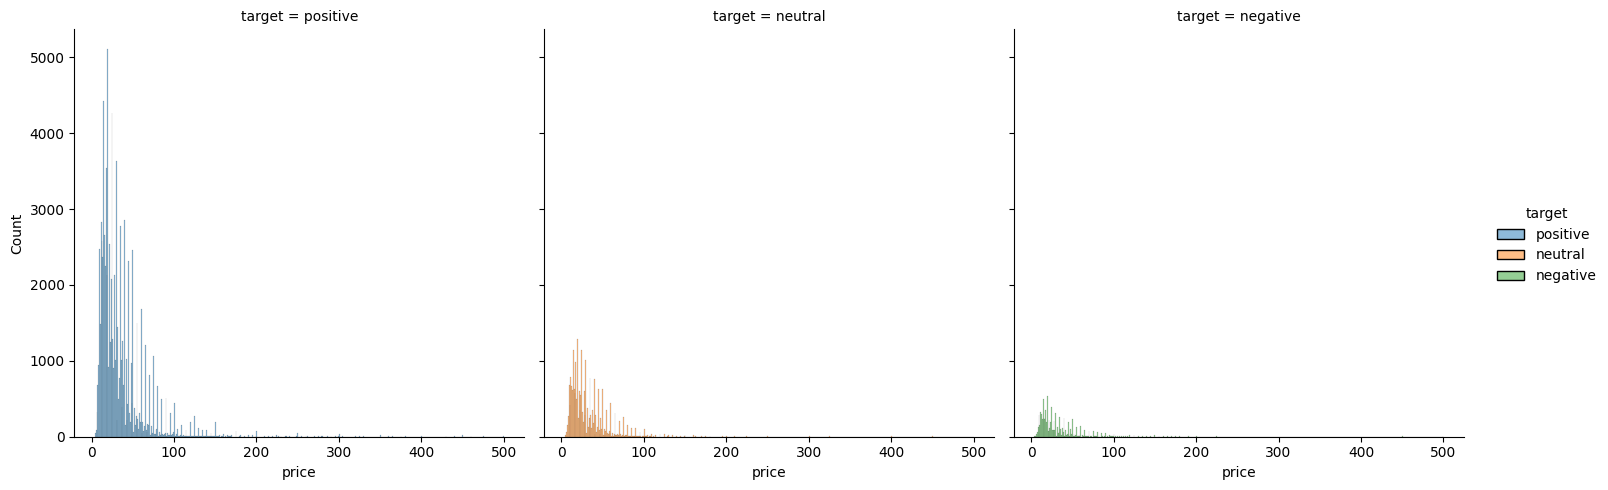

In [ ]:
# Filtra los datos para el rango de interés
xmin, xmax = 0, 500  # Define el rango del eje x
filtered_df = df[(df['price'] >= xmin) & (df['price'] <= xmax)]

# Crea el gráfico con el rango de valores filtrado
sns.displot(data=filtered_df, x="price", hue="target", col="target", kde=False)
plt.show()

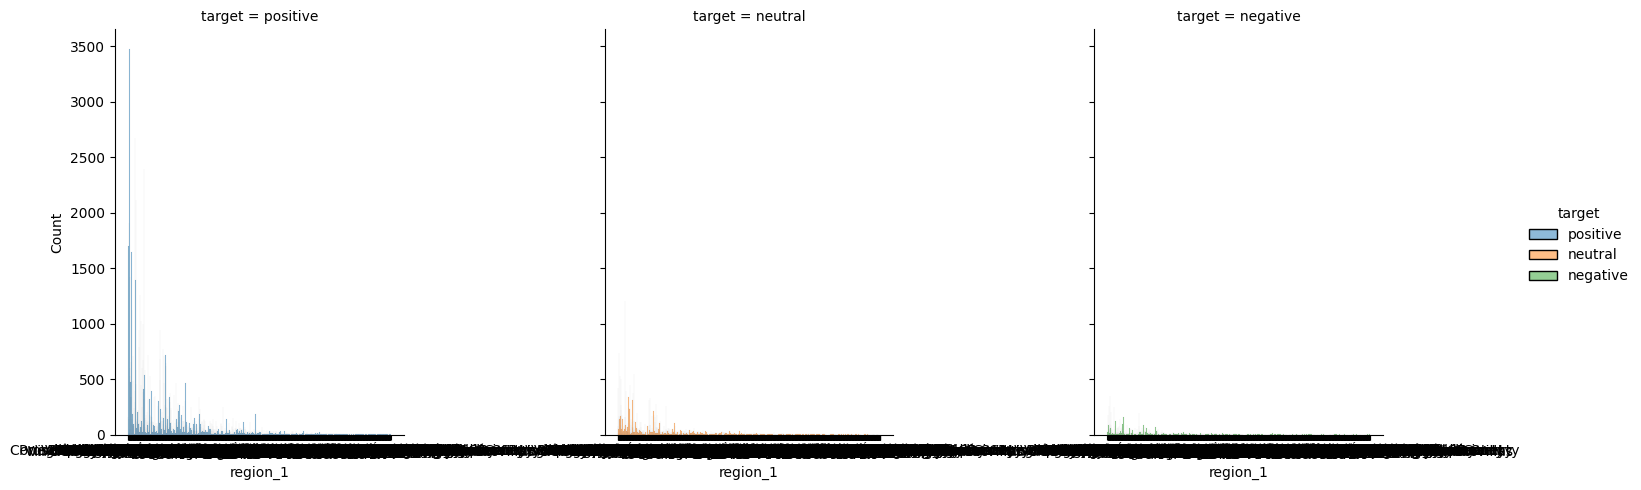

In [ ]:
sns.displot(data=df, x="region_1", hue="target", col="target")

In [ ]:
import matplotlib.pyplot as plt

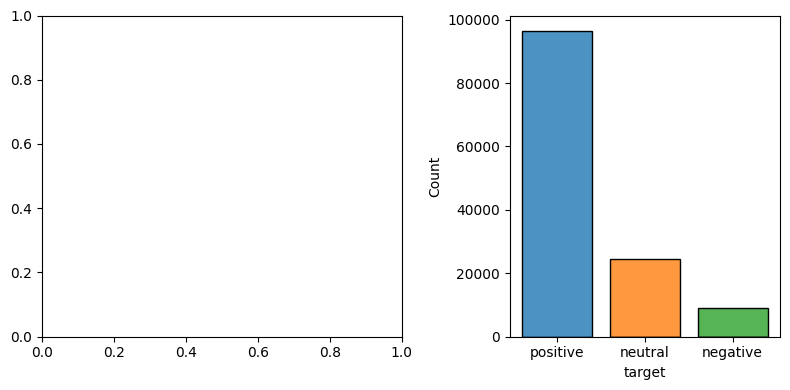

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
sns.histplot(data=df, x="target", hue="target", shrink=.8, alpha=.8, legend=False, ax=axs[1])
f.tight_layout()

In [ ]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 24.7 MB/s eta 0:00:00


In [ ]:
import dash
from dash import dcc, html
import plotly.express as px
import dash_core_components as dcc


import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd

# Inicializar la aplicación Dash
app = dash.Dash(__name__)

df = pd.DataFrame(df)

df = df.dropna(subset=['variety'])

# Gráfico 1: Distribución de Sentimientos
fig1 = px.bar(x=['positivo', 'negativo', 'neutral'], y=[200, 150, 100], title="Distribución de Sentimientos")

# Gráfico 2: Precio del vino según el país
fig2 = px.bar(df, x='country', y='price', title='Precio del Vino Según el País')

# Gráfico 3: Relación entre Target y País de Origen del Vino
fig3 = px.box(df, x='country', y='price', color='target', title='Relación entre Target y País de Origen del Vino')

# Gráfico 4: Variedad y Precio del Vino
fig4 = px.scatter(df, x='variety', y='price', title='Variedad y Precio del Vino')

# Gráfico 5: Variedad y Target
fig5 = px.sunburst(df, path=['variety', 'target'], values='price', title='Variedad vs  Target')

# Configuración del Layout de la Aplicación
app.layout = html.Div(children=[
    html.H1(children='Dashboard de Vinos'),

    dcc.Graph(
        id='sentiment-graph',
        figure=fig1
    ),
    dcc.Graph(
        id='price-country-graph',
        figure=fig2
    ),
    dcc.Graph(
        id='target-country-graph',
        figure=fig3
    ),
    dcc.Graph(
        id='variety-price-graph',
        figure=fig4
    ),
    dcc.Graph(
        id='variety-target-graph',
        figure=fig5
    )
])

# Ejecutar el servidor
if __name__ == '__main__':
    app.run_server(debug=True)



<IPython.core.display.Javascript object>

In [ ]:
#Para guardar el df en el computador
df.to_csv('df_processed.csv', index=False)
from google.colab import files
files.download('df_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>